In [1]:
from data import wiki
from data import corpus
import alignment

import nltk
import pandas as pd
import pickle
from tqdm import tqdm_notebook as tqdm

tqdm().pandas()

posts = wiki.load_posts()
pairs = corpus.get_reply_pairs(posts)
users = wiki.load_users(posts=posts)
network = wiki.load_network(reply_pairs=pairs, recreate=False)

In [2]:
# Run post annotations for `recreate=True` in `load_posts`
# posts = corpus.tokenize_posts(posts)
# posts = corpus.pos_tag_posts(posts)
# markers = alignment.load_markers()
# posts = corpus.detect_markers(posts, markers)
# wiki.save_posts(posts, overwrite=True)

# wiki.save_network(posts, overwrite=False)

# users = corpus.compute_centrality(users, network, log_normalize=True)
# wiki.save_users(users, overwrite=True)

In [3]:
df = pd.merge(posts, users, left_on='user', right_index=True)

In [4]:
# define highly-central users as users having centrality 
# one stddev above the mean (for log-noramlized centrality)

threshold = users.centrality.mean() + users.centrality.std()
users['highly_central'] = (users['centrality'] > threshold)
df['highly_central'] = (df['centrality'] > threshold)
users.highly_central.value_counts()

False    29007
True      1893
Name: highly_central, dtype: int64

In [5]:
users.highly_central.value_counts()

False    29007
True      1893
Name: highly_central, dtype: int64

In [6]:
admin_pop = len(users[users.admin == True])
admin_posts = len(df[df.admin == True])
central_pop = len(users[users.highly_central == True])
central_posts = len(df[df.highly_central == True])

print("Total users: {}".format(len(users)))
print("Admin pop: {} (%{:04.2f})".format(admin_pop, 100 * (admin_pop / len(users))))
print("Central pop: {} (%{:04.2f})".format(central_pop, 100 * (central_pop / len(users))))
print("Overlap: {} users".format(len(users[(users.admin == True) & (users.highly_central==True)])))
print()
print("Total posts: {}".format(len(df)))
print("Admin posts: {} (%{:04.2f})".format(admin_posts, 100 * (admin_posts / len(df))))
print("Central posts: {} (%{:04.2f})".format(central_posts, 100 * (central_posts / len(df))))
print("Overlap: {} users".format(len(df[(df.admin == True) & (df.highly_central==True)])))


Total users: 30900
Admin pop: 1812 (%5.86)
Central pop: 1893 (%6.13)
Overlap: 588 users

Total posts: 376923
Admin posts: 115783 (%30.72)
Central posts: 178078 (%47.25)
Overlap: 83849 users


/Users/xnobwi/.virtualenvs/lasn/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/xnobwi/.virtualenvs/lasn/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


([array([   2.,    4.,    0.,    0.,    0.,    9.,   82.,  580., 1034.,
           59.]),
  array([2.2200e+02, 6.3000e+01, 0.0000e+00, 4.0000e+00, 3.3000e+01,
         4.9200e+02, 5.2590e+03, 1.3889e+04, 5.2290e+03, 1.4900e+02])],
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 2 Lists of Patches objects>)

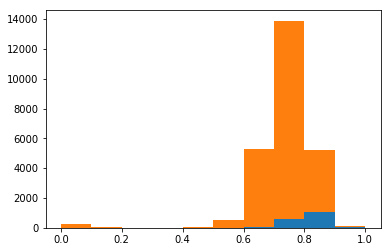

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt
x1 = [user.centrality for i, user in users[users.admin].iterrows()]
x2 = [user.centrality for i, user in users[~users.admin].iterrows()]
plt.figure()
plt.hist([x1,x2], stacked=True)

In [8]:
from collections import Counter
def get_ngrams(n, tokens):
    return zip(*(tokens[i:] for i in range(n)))

pos_trigrams = df.pos_tags.progress_apply(lambda x: Counter(list(get_ngrams(3, x))))
df['pos_trigrams'] = pos_trigrams

In [9]:
# trigram_counts = Counter()
# for c in tqdm(df.pos_trigrams):
#     trigram_counts += c
with open('trigram_counts.pickle', 'rb') as f:
    trigram_counts = pickle.load(f)

In [10]:
trigram_counts_admin = Counter()
for c in tqdm(df[df.admin == True].pos_trigrams):
    trigram_counts_admin += c

In [11]:
trigram_counts_central = Counter()
for c in tqdm(df[df.highly_central == True].pos_trigrams):
    trigram_counts_central += c

In [12]:
import math

def KLD(P, Q):
    return {i: P[i] * math.log(P[i] / Q[i], 2) if i in P else 0 for i in Q}

def count_to_freq(counter):
    total = sum(counter.values())
    return {i: counter[i]/total for i in counter}

In [13]:
trigram_freq = count_to_freq(trigram_counts)
trigram_freq_admin = count_to_freq(trigram_counts_admin)
trigram_freq_central = count_to_freq(trigram_counts_central)

In [14]:
admin_diverg = KLD(trigram_freq_admin, trigram_freq)
central_diverg = KLD(trigram_freq_central, trigram_freq)

In [15]:
pos_admin_diverg = {k:v for (k,v) in admin_diverg.items() if v >= 0}
neg_admin_diverg = {k:v for (k,v) in admin_diverg.items() if v < 0}

pos_central_diverg = {k:v for (k,v) in central_diverg.items() if v >= 0}
neg_central_diverg = {k:v for (k,v) in central_diverg.items() if v < 0}

top_pos_admin = sorted(pos_admin_diverg.items(), key=lambda x: x[1], reverse=True)[:20]
top_neg_admin = sorted(neg_admin_diverg.items(), key=lambda x: x[1], reverse=False)[:20]

top_pos_central = sorted(pos_central_diverg.items(), key=lambda x: x[1], reverse=True)[:20]
top_neg_central = sorted(neg_central_diverg.items(), key=lambda x: x[1], reverse=False)[:20]

In [16]:
def find_sub_list(sl,l):
    results=[]
    sll=len(sl)
    for ind in (i for i,e in enumerate(l) if e==sl[0]):
        if l[ind:ind+sll]==sl:
            results.append((ind,ind+sll-1))
    return results

def get_top_instances(top, ngram_row='pos_trigrams'):
    top_instances = {pos[0]: Counter() for pos in top}
    for _, row in tqdm(df.iterrows(), total=len(df)):
        for pos_ngram, _ in top:
            if pos_ngram in row[ngram_row]:
                locs = find_sub_list(list(pos_ngram), row['pos_tags'])
                ngrams = [tuple(row['tokens'][loc[0]:loc[1]+1]) for loc in locs]
                top_instances[pos_ngram].update(ngrams)
    return top_instances

In [17]:
top_pos_instances_admin = get_top_instances(top_pos_admin)
top_neg_instances_admin = get_top_instances(top_neg_admin)
top_pos_instances_central = get_top_instances(top_pos_central)
top_neg_instances_central = get_top_instances(top_neg_central)

In [18]:
def print_top_pos(top_pos):
    print('{:^12} {:^8}'.format('n-gram', 'KLD weight'))
    for (pos_seq, kld) in top_pos:
        pos_str = ('{:3} '*len(pos_seq)).format(*pos_seq)
        print("{} {:.6f}".format(pos_str, kld))

In [19]:
def print_top_instances(top, instances, freqs, counts):
    for pos, kld in top:
        freq = freqs[pos]
        count = counts[pos]
        pos_str = ('{:3} '*len(pos)).format(*pos)
        print(pos_str, 'KLD:', kld, 'freq:', freq, 'count:', count)
        top_inst = count_to_freq(instances[pos]) 
        top_inst = sorted(top_inst.items(), key=lambda x: x[1], reverse=True)[:5] # display top 5
        print('{:20} {:8}'.format('instance', 'rel. freq.'))
        for inst, freq in top_inst:
            print('{:20} {:.6f}'.format(' '.join(inst), freq))
        print()

In [20]:
print("Admin KLD\t", sum(admin_diverg.values()))
print("Central KLD\t", sum(central_diverg.values()))

Admin KLD	 0.012055585611230324
Central KLD	 0.0056654634165668625


In [21]:
print("Top indicative trigrams (admins)")
print_top_pos(top_pos_admin)
print()
print("Top indicative trigrams (highly central)")
print_top_pos(top_pos_central)

Top indicative trigrams (admins)
   n-gram    KLD weight
NNP NNP :    0.001072
NNP :   NNP  0.000978
PRP MD  VB   0.000762
:   NNP NNP  0.000703
JJ  NNP :    0.000561
IN  PRP VBP  0.000557
NN  .   :    0.000453
,   CC  PRP  0.000435
''  RB  :    0.000384
DT  NN  ,    0.000382
NN  ,   CC   0.000375
,   PRP MD   0.000363
.   :   ''   0.000350
JJ  TO  VB   0.000347
VB  DT  NN   0.000347
MD  RB  VB   0.000336
.   :   )    0.000332
NN  ''  RB   0.000318
RB  :   NNP  0.000317
CC  ''  NN   0.000314

Top indicative trigrams (highly central)
   n-gram    KLD weight
PRP VBP RB   0.000371
PRP MD  VB   0.000335
IN  PRP VBP  0.000284
NN  .   NN   0.000243
.   :   )    0.000242
,   CC  PRP  0.000226
:   NN  .    0.000224
MD  RB  VB   0.000204
DT  NN  ,    0.000183
TO  VB  IN   0.000170
NN  ,   CC   0.000166
PRP MD  RB   0.000162
PRP VBP JJ   0.000159
VBP RB  VB   0.000157
CC  PRP VBP  0.000156
JJ  TO  VB   0.000153
.   NN  :    0.000151
:   PRP VBP  0.000143
NNP :   NNP  0.000143
:   NNP CC   0.0001

In [22]:
print_top_instances(top_pos_admin, top_pos_instances_admin, trigram_freq, trigram_counts)

NNP NNP :    KLD: 0.001072474216740806 freq: 0.002995493612019941 count: 61288
instance             rel. freq.
[ WP :               0.292019
[ User :             0.233278
[ Wikipedia :        0.213226
[ Special :          0.041198
] ] -                0.020660

NNP :   NNP  KLD: 0.0009782339834676016 freq: 0.0028204208715445554 count: 57706
instance             rel. freq.
Wikipedia : Criteria 0.012604
WP : CSD             0.010245
Wikipedia : Media    0.009340
WP : RS              0.009324
WP : V               0.008306

PRP MD  VB   KLD: 0.0007616047825223614 freq: 0.0074848239744278455 count: 153140
instance             rel. freq.
it would be          0.024598
I 'd like            0.014189
I would like         0.013128
it should be         0.012740
I 'll be             0.011889

:   NNP NNP  KLD: 0.0007031816237219995 freq: 0.0027750642263292685 count: 56778
instance             rel. freq.
: RS ]               0.008143
: Monotype Corsiva   0.006973
: V ]                0.006801
: BLP 

In [23]:
print_top_instances(top_pos_central, top_pos_instances_central, trigram_freq, trigram_counts)

PRP VBP RB   KLD: 0.0003708216474701002 freq: 0.0048782342697118244 count: 99809
instance             rel. freq.
I do n't             0.226265
I 'm not             0.109136
you do n't           0.041904
I am not             0.036868
I have n't           0.028742

PRP MD  VB   KLD: 0.00033520128551298487 freq: 0.0074848239744278455 count: 153140
instance             rel. freq.
it would be          0.024598
I 'd like            0.014189
I would like         0.013128
it should be         0.012740
I 'll be             0.011889

IN  PRP VBP  KLD: 0.0002840675103482427 freq: 0.004982486127733599 count: 101942
instance             rel. freq.
If you have          0.038286
if you have          0.023166
that you have        0.021291
that you are         0.019101
if you want          0.018776

NN  .   NN   KLD: 0.0002425927313100996 freq: 0.001190660812596557 count: 24361
instance             rel. freq.
\/\/en.wikipedia.org\/w\/index.php ? title=User_talk 0.124597
\/\/en.wikipedia.org\/w\/index.p

In [24]:
print("Top anti-indicative trigrams (admins)")
print_top_pos(top_neg_admin)
print()
print("Top anti-indicative trigrams (highly central)")
print_top_pos(top_neg_central)

Top anti-indicative trigrams (admins)
   n-gram    KLD weight
NNP NNP NNP  -0.001735
IN  DT  NNP  -0.000605
NN  IN  DT   -0.000484
DT  NNP NNP  -0.000473
NNP NNP NN   -0.000314
NN  IN  NNP  -0.000306
NNP ,   NNP  -0.000280
NN  NN  NN   -0.000277
DT  NNP NN   -0.000268
NNP IN  NNP  -0.000258
DT  NN  IN   -0.000244
NNP NNP ''   -0.000240
JJ  NN  IN   -0.000239
NN  NNP NN   -0.000214
.   PRP VBD  -0.000209
MD  PRP VB   -0.000194
NN  CC  NN   -0.000186
NNP NN  NN   -0.000180
NNP NNP ,    -0.000180
NN  .   PRP  -0.000176

Top anti-indicative trigrams (highly central)
   n-gram    KLD weight
NNP NNP NNP  -0.002825
NNP NNP NN   -0.000512
IN  DT  NNP  -0.000451
DT  NNP NNP  -0.000434
NN  NN  NN   -0.000418
NN  IN  DT   -0.000386
NN  NNP NNP  -0.000341
NN  IN  NNP  -0.000270
NNP NNP .    -0.000269
IN  NNP NNP  -0.000267
NNP NNP ,    -0.000246
NNP NN  NN   -0.000245
JJ  NNP NNP  -0.000244
JJ  NN  NN   -0.000227
NN  NNP NN   -0.000223
NNP NNP IN   -0.000215
NNP NN  NNP  -0.000209
NNP IN  NNP  -0.

In [25]:
print_top_instances(top_neg_admin, top_neg_instances_admin, trigram_freq, trigram_counts)

NNP NNP NNP  KLD: -0.001735267680488634 freq: 0.017511379605941662 count: 358284
instance             rel. freq.
[ [ WP               0.043809
[ [ User             0.039621
[ [ Wikipedia        0.039496
< \/font >           0.015754
] ] <                0.012071

IN  DT  NNP  KLD: -0.0006052912056666259 freq: 0.003026138672957425 count: 61915
instance             rel. freq.
on the [             0.035191
at the [             0.025884
of the [             0.024277
in the [             0.021935
for the [            0.008312

NN  IN  DT   KLD: -0.00048448798648708855 freq: 0.008467469827933604 count: 173245
instance             rel. freq.
part of the          0.012679
look at the          0.010065
top of the           0.005185
article on the       0.005021
end of the           0.004731

DT  NNP NNP  KLD: -0.0004728843100016021 freq: 0.00188875236821072 count: 38644
instance             rel. freq.
the [ [              0.388578
The [ [              0.006875
the Arbitration Committee 0.004248

In [26]:
print_top_instances(top_neg_central, top_neg_instances_central, trigram_freq, trigram_counts)

NNP NNP NNP  KLD: -0.0028253733059225195 freq: 0.017511379605941662 count: 358284
instance             rel. freq.
[ [ WP               0.043809
[ [ User             0.039621
[ [ Wikipedia        0.039496
< \/font >           0.015754
] ] <                0.012071

NNP NNP NN   KLD: -0.0005123390506811409 freq: 0.0026356218677094263 count: 53925
instance             rel. freq.
[ User talk          0.113268
[ [ Talk             0.064172
] ] article          0.056939
> ] ]                0.035119
[ Wikipedia talk     0.027555

IN  DT  NNP  KLD: -0.0004511215571532975 freq: 0.003026138672957425 count: 61915
instance             rel. freq.
on the [             0.035191
at the [             0.025884
of the [             0.024277
in the [             0.021935
for the [            0.008312

DT  NNP NNP  KLD: -0.0004343905107654599 freq: 0.00188875236821072 count: 38644
instance             rel. freq.
the [ [              0.388578
The [ [              0.006875
the Arbitration Committee 0.004248

In [27]:
pos_fourgrams = df.pos_tags.progress_apply(lambda x: Counter(list(get_ngrams(4, x))))
df['pos_fourgrams'] = pos_fourgrams

In [28]:
# fourgrams_counts = Counter()
# for c in tqdm(df.pos_fourgrams):
#     fourgrams_counts += c
with open('fourgram_counts.pickle', 'rb') as f:
    fourgram_counts = pickle.load(f)

In [29]:
fourgram_counts_admin = Counter()
for c in tqdm(df[df.admin == True].pos_fourgrams):
    fourgram_counts_admin += c
    
fourgram_counts_central = Counter()
for c in tqdm(df[df.highly_central == True].pos_fourgrams):
    fourgram_counts_central += c

In [30]:
fourgram_freq = count_to_freq(fourgram_counts)
fourgram_freq_admin = count_to_freq(fourgram_counts_admin)
fourgram_freq_central = count_to_freq(fourgram_counts_central)

In [31]:
admin_diverg4 = KLD(fourgram_freq_admin, fourgram_freq)
central_diverg4 = KLD(fourgram_freq_central, fourgram_freq)

In [32]:
pos_admin_diverg4 = {k:v for (k,v) in admin_diverg4.items() if v >= 0}
neg_admin_diverg4 = {k:v for (k,v) in admin_diverg4.items() if v < 0}

pos_central_diverg4 = {k:v for (k,v) in central_diverg4.items() if v >= 0}
neg_central_diverg4 = {k:v for (k,v) in central_diverg4.items() if v < 0}

top_pos_admin4 = sorted(pos_admin_diverg4.items(), key=lambda x: x[1], reverse=True)[:20]
top_neg_admin4 = sorted(neg_admin_diverg4.items(), key=lambda x: x[1], reverse=False)[:20]

top_pos_central4 = sorted(pos_central_diverg4.items(), key=lambda x: x[1], reverse=True)[:20]
top_neg_central4 = sorted(neg_central_diverg4.items(), key=lambda x: x[1], reverse=False)[:20]

In [33]:
top_pos_instances_admin4 = get_top_instances(top_pos_admin4, ngram_row='pos_fourgrams')
top_neg_instances_admin4 = get_top_instances(top_neg_admin4, ngram_row='pos_fourgrams')
top_pos_instances_central4 = get_top_instances(top_pos_central4, ngram_row='pos_fourgrams')
top_neg_instances_central4 = get_top_instances(top_neg_central4, ngram_row='pos_fourgrams')

In [34]:
admin_diverg4 = KLD(fourgram_freq_admin, fourgram_freq)
central_diverg4 = KLD(fourgram_freq_central, fourgram_freq)
print("Admin KLD\t", sum(admin_diverg4.values()))
print("Central KLD\t", sum(central_diverg4.values()))

Admin KLD	 0.05291102646658371
Central KLD	 0.02686652356856986


In [35]:
print("Top indicative four-grams (admins)")
print_top_pos(top_pos_admin4)
print()
print("Top indicative four-grams (highly central)")
print_top_pos(top_pos_central4)

Top indicative four-grams (admins)
   n-gram    KLD weight
NNP NNP NNP :    0.000920
:   NNP NNP NNP  0.000675
NNP :   NNP NNP  0.000656
NNP NNP :   NNP  0.000637
NN  ''  RB  :    0.000402
.   :   ''  ''   0.000350
''  RB  :   NNP  0.000335
:   CC  ''  NN   0.000322
IN  NNP NNP NNP  0.000285
,   PRP MD  VB   0.000282
JJ  NNP :   NNP  0.000272
JJ  JJ  NNP :    0.000271
NN  :   CC  ''   0.000256
:   NN  :   CC   0.000255
IN  DT  NN  ,    0.000242
JJ  NN  ''  RB   0.000225
PRP MD  RB  VB   0.000205
.   IN  PRP VBP  0.000192
CC  ''  NN  NN   0.000190
VBD #   CD  :    0.000189

Top indicative four-grams (highly central)
   n-gram    KLD weight
NN  :   NN  .    0.000229
:   NN  .   NN   0.000219
.   :   ''  ''   0.000166
NN  .   NN  :    0.000153
.   NN  :   NNP  0.000146
''  RB  :   NNP  0.000142
PRP MD  RB  VB   0.000133
NN  :   NNP CC   0.000133
NN  ''  RB  :    0.000127
.   VB  JJ  NN   0.000125
:   NNP CC  NNP  0.000118
,   CC  PRP VBP  0.000116
RB  :   NNP ,    0.000115
PRP VBP RB  VB 

In [36]:
print_top_instances(top_pos_admin4, top_pos_instances_admin4, fourgram_freq, fourgram_counts)

NNP NNP NNP :    KLD: 0.0009201992550276906 freq: 0.0024572175894019242 count: 49420
instance             rel. freq.
[ [ WP :             0.319465
[ [ Wikipedia :      0.264683
[ [ User :           0.191357
[ [ Special :        0.048638
[ [ User_talk :      0.024744

:   NNP NNP NNP  KLD: 0.0006752042156881623 freq: 0.002209755591375753 count: 44443
instance             rel. freq.
: RS ] ]             0.009696
: V ] ]              0.008204
: BLP ] ]            0.007969
: Consensus|consensus ] ] 0.007478
: ANI ] ]            0.006516

NNP :   NNP NNP  KLD: 0.0006557770616358343 freq: 0.0019410129553838994 count: 39038
instance             rel. freq.
WP : RS ]            0.012164
WP : V ]             0.010300
WP : BLP ]           0.009846
Wikipedia : Consensus|consensus ] 0.008986
WP : NPOV ]          0.008006

NNP NNP :   NNP  KLD: 0.0006365259078635571 freq: 0.0018547965389528404 count: 37304
instance             rel. freq.
[ Wikipedia : Media  0.012524
[ WP : CSD           0.010453
[ 

In [37]:
print_top_instances(top_pos_central4, top_pos_instances_central4, fourgram_freq, fourgram_counts)

NN  :   NN  .    KLD: 0.00022873884964606152 freq: 0.0010657224162533556 count: 21434
instance             rel. freq.
http : \/\/en.wikipedia.org\/w\/index.php ? 0.799279
http : \/\/www.youtube.com\/watch ? 0.021027
http : \/\/www.google.com\/search ? 0.011041
https : \/\/secure.wikimedia.org\/wikipedia\/en\/w\/index.php ? 0.010777
http : \/\/commons.wikimedia.org\/w\/index.php ? 0.003431

:   NN  .   NN   KLD: 0.00021913431867276692 freq: 0.0008630591444119506 count: 17358
instance             rel. freq.
: \/\/en.wikipedia.org\/w\/index.php ? title=User_talk 0.176423
: \/\/en.wikipedia.org\/w\/index.php ? title=Wikipedia 0.135785
: \/\/en.wikipedia.org\/w\/index.php ? title=Talk 0.081330
: \/\/en.wikipedia.org\/w\/index.php ? title=User 0.033021
: \/\/en.wikipedia.org\/w\/index.php ? title=Wikipedia_talk 0.029649

.   :   ''  ''   KLD: 0.00016605727460788968 freq: 8.402868729440008e-05 count: 1690
instance             rel. freq.
. -- ' ''            0.718110
. - '' '             0.105

In [38]:
print("Top anti-indicative trigrams (admins)")
print_top_pos(top_neg_admin4)
print()
print("Top anti-indicative trigrams (highly central)")
print_top_pos(top_neg_central4)

Top anti-indicative trigrams (admins)
   n-gram    KLD weight
NNP NNP NNP NNP  -0.001892
IN  DT  NNP NNP  -0.000272
NN  IN  DT  NNP  -0.000236
DT  NNP NNP NNP  -0.000186
IN  DT  NNP NN   -0.000165
JJ  NNP NNP NNP  -0.000157
DT  NN  IN  DT   -0.000156
IN  DT  NN  IN   -0.000152
NN  NN  NN  NN   -0.000142
NNP NNP IN  NNP  -0.000125
NNP NNP ,   NNP  -0.000123
NNP ,   NNP NNP  -0.000117
NN  CC  NN  CC   -0.000116
DT  JJ  NN  IN   -0.000115
DT  NNP NNP NN   -0.000115
JJ  NN  IN  DT   -0.000111
NNP IN  NNP NNP  -0.000107
NNP NNP NNP ''   -0.000104
NNP NNP NNP (    -0.000102
NN  IN  DT  JJ   -0.000102

Top anti-indicative trigrams (highly central)
   n-gram    KLD weight
NNP NNP NNP NNP  -0.001865
IN  DT  NNP NNP  -0.000262
NNP NNP NNP NN   -0.000233
DT  NNP NNP NNP  -0.000231
NN  IN  DT  NNP  -0.000202
JJ  NNP NNP NNP  -0.000186
DT  NN  IN  DT   -0.000183
NN  NNP NNP NNP  -0.000175
NN  NN  NN  NN   -0.000175
NN  :   NN  :    -0.000164
NN  :   NNP NNP  -0.000145
NNP NNP NNP .    -0.000144
NN 

In [39]:
central_from_admin_diverg3 = KLD(trigram_freq_central, trigram_freq_admin)
admin_from_central_diverg3 = KLD(trigram_freq_admin, trigram_freq_central)
central_from_admin_diverg4 = KLD(fourgram_freq_central, fourgram_freq_admin)
admin_from_central_diverg4 = KLD(fourgram_freq_admin, fourgram_freq_central)

In [40]:
print("Central-from-admin 3-gram KLD:\t", sum(central_from_admin_diverg3.values()))
print("Admin-from-central 3-gram KLD:\t", sum(admin_from_central_diverg3.values()))

print("Central-from-admin 4-gram KLD:\t", sum(central_from_admin_diverg4.values()))
print("Admin-from-central 4-gram KLD:\t", sum(admin_from_central_diverg4.values()))

Central-from-admin 3-gram KLD:	 0.007223121496530654
Admin-from-central 3-gram KLD:	 0.0084140362767782
Central-from-admin 4-gram KLD:	 0.018148856571174276
Admin-from-central 4-gram KLD:	 0.03756643745308383
